Contamos con una base de datos de transacciones realizadas entre 2010 y 2011, pertenecientes a una empresa minorista (https://www.kaggle.com/datasets/carrie1/ecommerce-data), en la cual encontramos las siguientes columnas:

*  InvoiceNo: Identificador de comprobante de compra (valores únicos)
*  StockCode: Identificador de cada item comprado (valores únicos)
*  Description: Descripción del producto comprado por el cliente
*  Quantity: Cantidad de unidades compradas de cada producto por el cliente
*  InvoiceDate: El día en el que el cliente realizó la compra de cierto producto
*  UnitePrice: El precio de cada unidad
*  CustomerID: Identificador de cliente (valores únicos)
*  País: El país en el que se realizó la compra

A partir de estos datos segmentaremos los clientes de la empresa en base a un análisis RFM (Recencia, Frecuencia y Valor monetario), empleando el algoritmo K-Means.

Los pasos a seguir son los siguientes

1.  Explorar los datos
2.  Crear las variables necesarias, considerando que realizaremos un análisis RFM
3.  Remover outliers
4.  Utilizar el algoritmo K-Means, junto al metodo del codo, para definir nuestro modelo
5.  Emplear el modelo creado para realizar predicciones
6.  Visualizar los datos y analizar los resultados obtenidos

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("carrie1/ecommerce-data")

In [ ]:
import pandas as pd
df=pd.read_csv("/content/data.csv",encoding='unicode_escape')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [ ]:
df.info()
#Observamos que en la columna de Customer ID se observan múltiples vacíos; sin embargo, estos conforman alrededor del 25% de los datos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df.describe()
#En nuestra columna cantidad, los valores negativos refieren a devoluciones

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Estas estadísticas nos permiten conocer el perfil de cada variable, identificando aspectos atípicos, por ejemplo, los vacíos en los identificadores de los clientes, y poder ir conociendo mejor la base de datos.

El análisis RFM consiste en analizar los siguientes comportamientos de nuestros clientes, en base a los cuales realizaremos la segmentación:

*  Recencia (Recency): Última vez que un cliente realizó una compra.
*  Frecuencia (Frequency): Cuántas veces un cliente realiza una compra.
*  Valor monetario (Monetary Value): El monto total pagado por el cliente.

Para poder crear nuestra variable recency debemos identificar la última vez que cada cliente ha realizado una compra, por lo que consideraremos las fechas de emision de los recibos.

In [ ]:
df["Date"] = pd.to_datetime(df["InvoiceDate"])
df['rank'] = df.sort_values(['CustomerID','Date']).groupby(['CustomerID'])['Date'].rank(method='min') #con el método se asigna el valor de 1 si un cliente ha realizado dos compras en la misma fecha
df_rec = df[df['rank']==1] #solo mantienes los de ranking 1, es decir, el registro de la última de compra para cada cliente
df_rec

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,rank
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,2010-12-01 08:26:00,1.0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,1.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,2010-12-01 08:26:00,1.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,1.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,1.0
...,...,...,...,...,...,...,...,...,...,...
541801,581578,22993,SET OF 4 PANTRY JELLY MOULDS,12,12/9/2011 12:16,1.25,12713.0,Germany,2011-12-09 12:16:00,1.0
541802,581578,22907,PACK OF 20 NAPKINS PANTRY DESIGN,12,12/9/2011 12:16,0.85,12713.0,Germany,2011-12-09 12:16:00,1.0
541803,581578,22908,PACK OF 20 NAPKINS RED APPLES,12,12/9/2011 12:16,0.85,12713.0,Germany,2011-12-09 12:16:00,1.0
541804,581578,23215,JINGLE BELL HEART ANTIQUE SILVER,12,12/9/2011 12:16,2.08,12713.0,Germany,2011-12-09 12:16:00,1.0


Creamos la columna recency en la cual enumeraremos de manera decreciente a los clientes según su fecha de compra, es decir, a aquel cliente que haya realizando la compra más reciente se le asignará 1.



In [ ]:
df_rec['recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days

<ipython-input-5-6ccb90a19d8b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rec['recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days


Para analizar la frecuencia (frequency) de compra agrupamos los registros según las fechas de compra y realizamos un conteo total, obteniendo la cantidad de veces que cada cliente ha comprado.

In [ ]:
#FRECUENCIA
freq = df_rec.groupby('CustomerID')['Date'].count()
df_freq = pd.DataFrame(freq).reset_index()
df_freq.columns = ['CustomerID','frequency']

In [ ]:
rec_freq = df_freq.merge(df_rec,on='CustomerID')
rec_freq.head()

,CustomerID,frequency,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,Date,rank,recency
0,12346.0,1,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,United Kingdom,2011-01-18 10:01:00,1.0,48
1,12347.0,31,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,12/7/2010 14:57,2.10,Iceland,2010-12-07 14:57:00,1.0,6
2,12347.0,31,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,12/7/2010 14:57,4.25,Iceland,2010-12-07 14:57:00,1.0,6
3,12347.0,31,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,12/7/2010 14:57,3.25,Iceland,2010-12-07 14:57:00,1.0,6
4,12347.0,31,537626,22492,MINI PAINT SET VINTAGE,36,12/7/2010 14:57,0.65,Iceland,2010-12-07 14:57:00,1.0,6


Con respecto al valor monetario (monetary value), calculamos el monto total gastado por el cliente, acumulando cada compra que ha realizado entre 2010 y 2011.

In [ ]:
rec_freq['total'] = rec_freq['Quantity']*df['UnitPrice']
m = rec_freq.groupby('CustomerID')['total'].sum()
m = pd.DataFrame(m).reset_index()
m.columns = ['CustomerID','monetary_value']
rfm = m.merge(rec_freq,on='CustomerID')
rfm.head()

,CustomerID,monetary_value,frequency,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,Date,rank,recency,total
0,12346.0,189248.25,1,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,United Kingdom,2011-01-18 10:01:00,1.0,48,189248.25
1,12347.0,1246.73,31,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,12/7/2010 14:57,2.10,Iceland,2010-12-07 14:57:00,1.0,6,40.68
2,12347.0,1246.73,31,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,12/7/2010 14:57,4.25,Iceland,2010-12-07 14:57:00,1.0,6,11.00
3,12347.0,1246.73,31,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,12/7/2010 14:57,3.25,Iceland,2010-12-07 14:57:00,1.0,6,40.68
4,12347.0,1246.73,31,537626,22492,MINI PAINT SET VINTAGE,36,12/7/2010 14:57,0.65,Iceland,2010-12-07 14:57:00,1.0,6,122.04


Por último, creamos un dataframe final en el que solo mantenemos las columnas Customer ID, recencia, frecuencia y valor monetario:

In [ ]:
finaldf = rfm[["CustomerID",'recency','frequency','monetary_value']]
finaldf.head()

,CustomerID,recency,frequency,monetary_value
0,12346.0,48,1,189248.25
1,12347.0,6,31,1246.73
2,12347.0,6,31,1246.73
3,12347.0,6,31,1246.73
4,12347.0,6,31,1246.73


In [ ]:
#OUTLIERS
import seaborn as sns
import matplotlib.pyplot as plt

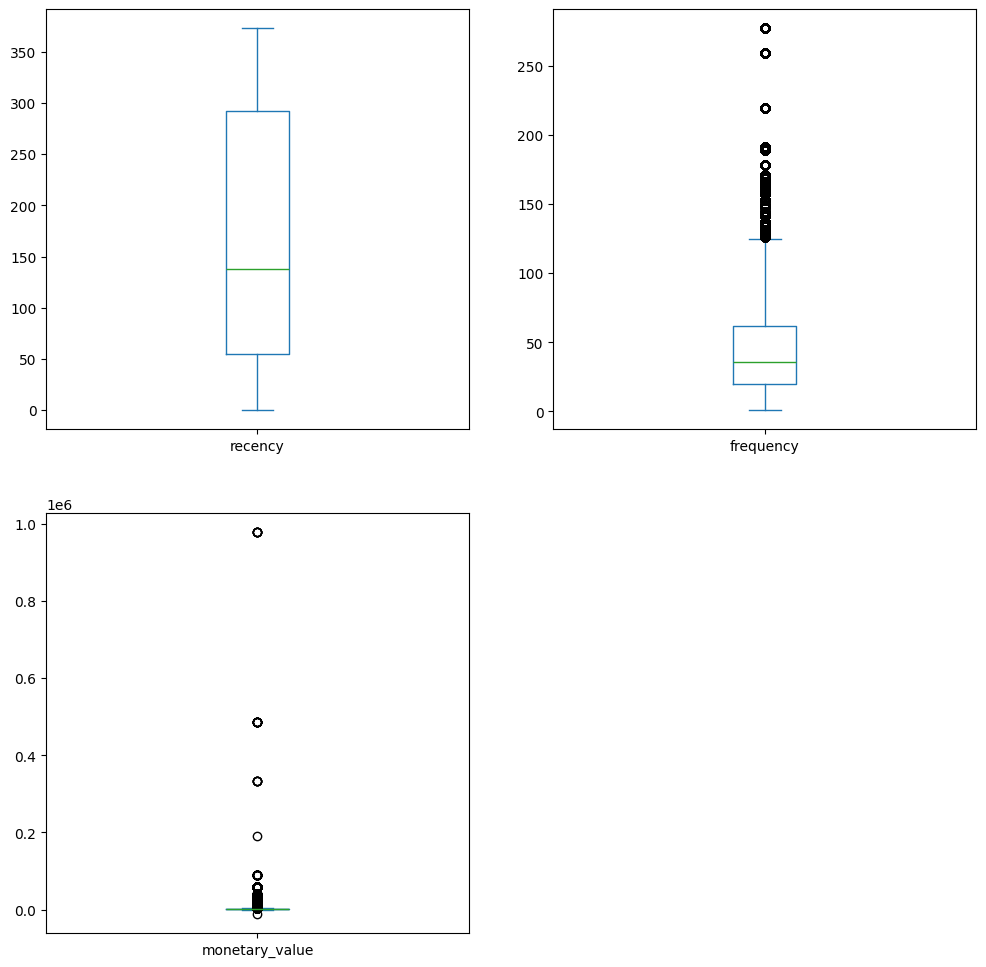

In [ ]:
finaldf[['recency','frequency','monetary_value']].plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False, figsize=[12,12])
plt.show()

A partir de los gráficos, observamos que en la columna de frecuencia y valor monetario hallamos ciertos outliers. Para poder identificar estos en mayor detalle, debemos calcular los z-scores, los cuales no ayudan a reconocer cuántos puntos de desviación estándar los valores se alejan de la media, y filtraremos aquellos registros cuyos z-scores sean mayores a 3, siguiendo la regla empírica.



In [ ]:
from scipy import stats
import numpy as np
finaldf = finaldf[["CustomerID",'recency','frequency','monetary_value']]
z_scores = np.abs(stats.zscore(finaldf[['recency','frequency','monetary_value']]))
filtered_entries = (z_scores < 3).all(axis=1)
finaldf = finaldf[filtered_entries]
finaldf

,CustomerID,recency,frequency,monetary_value
1,12347.0,6,31,1246.73
2,12347.0,6,31,1246.73
3,12347.0,6,31,1246.73
4,12347.0,6,31,1246.73
5,12347.0,6,31,1246.73
...,...,...,...,...
100805,18287.0,172,29,863.40
100806,18287.0,172,29,863.40
100807,18287.0,172,29,863.40
100808,18287.0,172,29,863.40


Por último, eliminamos los duplicados y estandarizamos los datos.

In [ ]:
from sklearn.preprocessing import StandardScaler
finaldf = finaldf.drop_duplicates()
customerid=finaldf["CustomerID"]
features = finaldf[['recency','frequency','monetary_value']]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = ['recency', 'frequency', 'monetary_value'], index=customerid)
scaled_features

,recency,frequency,monetary_value
CustomerID,,,
12347.0,-1.196365,0.380192,0.185220
12348.0,-1.120311,-0.258871,1.966203
12349.0,1.752831,2.297383,0.401413
12350.0,-0.714691,-0.258871,-0.217719
12352.0,-0.596385,-0.350166,0.011420
...,...,...,...
18280.0,-0.435827,-0.578403,-0.405661
18281.0,0.383863,-0.715345,-0.485554
18282.0,0.840186,-0.715345,-0.446264


Al aplicar el algoritmo K-Means debemos definir en cuántos clusters agruparemos los datos, para esto usamos la técnica del codo, la cual nos permite reconocer la cantidad de clusters más óptima.

Text(0, 0.5, 'Inertia')

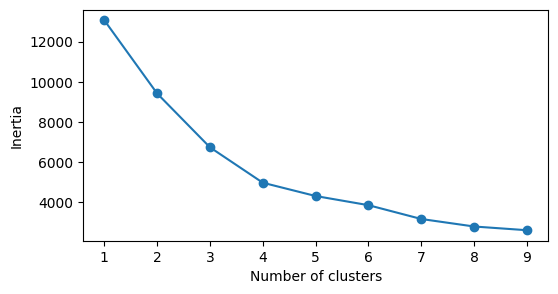

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

SSE = []
for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(scaled_features)
    SSE.append(kmeans.inertia_)

frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(6,3))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [ ]:
kmeans = KMeans(n_clusters = 4, init='k-means++', random_state=7)
kmeans.fit(scaled_features)

KMeans(n_clusters=4, random_state=7)

Para evaluar el desempeño de nuestro modelo, observamos el silhouette score. Este puntaje tiene un rango de 1 a -1, por lo que al obtener 0.44 comprendemos que, si bien existe un solapamiento, nuestro agrupamiento es adecuado.

In [ ]:
print(silhouette_score(scaled_features, kmeans.labels_, metric='euclidean'))

0.4360390324504537


A continuación, predecimos los clusters a los que pertenecen nuestros clientes y adicionamos estos a nuestro dataframe final.

In [ ]:
pred = kmeans.predict(scaled_features)
frame = pd.DataFrame(finaldf)
frame['cluster'] = pred
frame

,CustomerID,recency,frequency,monetary_value,cluster
1,12347.0,6,31,1246.73,1
32,12348.0,15,17,4311.90,1
49,12349.0,355,73,1618.81,0
122,12350.0,63,17,553.25,1
139,12352.0,77,15,947.61,1
...,...,...,...,...,...
100700,18280.0,96,10,229.79,1
100710,18281.0,193,7,92.29,2
100717,18282.0,247,7,159.91,2
100724,18283.0,36,57,201.54,0


In [ ]:
clusters={}
for i in range(4):
  clusters[i]=frame.loc[frame["cluster"]==i, "CustomerID"]

In [ ]:
clusterzero=rfm[rfm["CustomerID"].isin(clusters[0].values)]
clusterzero[clusterzero["total"]>0].groupby("Description").sum("Quantity").sort_values("Quantity", ascending=False).head(10)

,CustomerID,monetary_value,frequency,Quantity,UnitPrice,rank,recency,total
Description,,,,,,,,
WORLD WAR 2 GLIDERS ASSTD DESIGNS,720825.0,117884.31,3113,3264,13.10,46.0,7972,12288.48
PACK OF 72 RETROSPOT CAKE CASES,1741119.0,242602.21,8941,1576,62.44,114.0,16762,4923.05
60 TEATIME FAIRY CAKE CASES,1407537.0,188461.25,7427,1184,51.02,93.0,13220,4143.22
POPART WOODEN PENCILS ASST,158216.0,40572.18,959,1100,0.56,10.0,2798,4457.00
ASSORTED COLOUR BIRD ORNAMENT,1506645.0,174768.00,7597,1092,165.62,98.0,15943,6486.31
JAM MAKING SET PRINTED,1419415.0,199447.08,6697,1073,135.90,94.0,13441,3918.96
HOMEMADE JAM SCENTED CANDLES,990384.0,142956.86,4717,1056,95.50,66.0,8888,3934.56
MINI PAINT SET VINTAGE,341772.0,57184.00,1667,1044,14.95,23.0,3552,2790.36
PACK OF 60 PINK PAISLEY CAKE CASES,1090235.0,151627.19,5643,1007,39.89,73.0,13003,3713.54


Por último, visualizaremos los datos:

A partir de esta tabla, graficaremos los valores cada grupo de clientes.

In [ ]:
avg_df = frame.groupby(['cluster']).mean()
avg_df

,CustomerID,recency,frequency,monetary_value
cluster,,,,
0,15299.623984,163.079268,69.193089,1804.551301
1,15301.619488,64.762705,15.049559,568.673847
2,15318.227983,281.519176,18.840199,728.417940
3,15158.027397,160.630137,31.602740,10587.056575


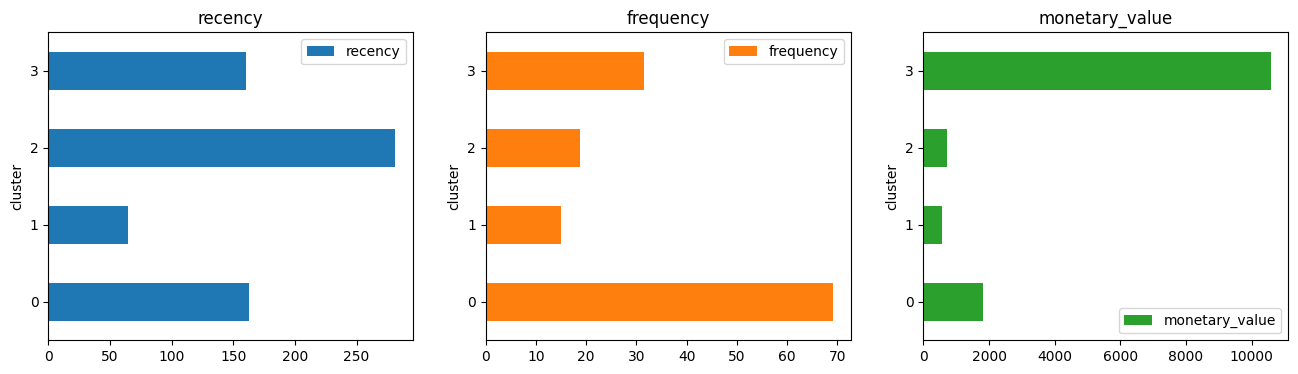

In [ ]:
avg_df[["recency", "frequency", "monetary_value"]].plot(kind='barh', subplots=True, layout=(1,3), sharex=False, sharey=False, figsize=(16,4))
plt.show()

**Descripción de clusters:**
*  0: compran con mucha frecuencia, pero no gastan mucho dinero al comprar
*  1: aquellos que no compran hace un tiempo y cuando lo hacen no es de manera frecuente ni gastan mucho dinero
*  2: aquellos clientes que compraron recientemente, pero no suelen comprar con frecuencia y ni gastar mucho dinero
*  3: gastan grandes cantidades de dinero al comprar y compran con mediana frecuencia

**Sugerencias**

Estas son las siguientes sugerencias para cada grupo de clientes:
*  0: Estos clientes deben recibir una invitación a una suscripción, brindando descuentos entre 10%-20% semanales, incitando a que realicen una mayor cantidad de compras.
*  1: Mostrarles mensualmente productos populares o más recomendados.
*  2: Mostrar a estos clientes el sistema de suscripción (dependiendo de la cantidad de compras realizadas, obtienen mayores descuentos y beneficios) y brindarles un descuento de 5% acumulativo por cada compra de cierto monto. Realizar un seguimiento.